In [5]:
import pandas as pd

# Path to unprocessed data file
initial_file = "V2_Perm_Clean.txt"

# Extract data into a dictionary
with open(initial_file, 'r') as input_file:
    # Master data list and permitivity value tracker
    data = []
    current_perm = None

    # Process all lines
    for line in input_file:
        curr_data = {}
        line = line.strip()

        # Skip blank lines
        if not line:
            continue

        # Header hit
        if line.startswith("#"):
            if "{Tested_Perm" in line:
                # Extract the tested perm from the line
                first_cut = line.split(";")[0]
                next_cut = first_cut.split("=")[2]
                current_perm = float(next_cut)
            else:
                # Skip extraneous headers
                continue

        # Data line found
        else:
            # Extract the frequency and s_param from the line
            frequency, s_param = line.split()
            frequency, s_param = float(frequency), float(s_param)

            # Add the data to the current data dictionary
            curr_data["Frequency"] = frequency
            curr_data["S_Param"] = s_param
            curr_data["Tested_Perm"] = current_perm

            # Add the current set of data to the list of data
            data.append(curr_data)

# Convert to a dataframe    
df = pd.DataFrame(data)
df


,Tested_Perm,Frequency,S_Param
0,40.0,0.00,-90.870470
1,40.0,0.01,-56.950480
2,40.0,0.02,-50.875755
3,40.0,0.03,-47.333106
4,40.0,0.04,-44.822122
...,...,...,...
21028,80.0,9.96,-7.507281
21029,80.0,9.97,-7.523806
21030,80.0,9.98,-7.539987
21031,80.0,9.99,-7.555828


In [7]:
# Create CSV file of processed data
df.to_csv("V2_Perm_Processed.csv", index=False)

In [13]:
from sklearn.model_selection import train_test_split

# Separate the data into features and target
X = df[["Frequency", "S_Param"]]
y = df["Tested_Perm"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=602, shuffle=True)

In [33]:
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.2, max_depth=7)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
# Make predictions
y_pred = model.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 5.3447


In [45]:
def accuracy_within_threshold(y_true, y_pred, threshold=0.15):
    relative_errors = np.abs(y_pred - y_true) / y_true
    accuracy = np.mean(relative_errors <= threshold) * 100

    return accuracy

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
    model_accuracy = accuracy_within_threshold(y_test, y_pred, threshold)
    print(f"Accuracy with {threshold * 100}% tolerance: {model_accuracy:.2f}%")


Accuracy with 5.0% tolerance: 78.42%
Accuracy with 10.0% tolerance: 87.16%
Accuracy with 15.0% tolerance: 91.68%
Accuracy with 20.0% tolerance: 93.94%
Accuracy with 25.0% tolerance: 95.89%
Accuracy with 30.0% tolerance: 97.08%
Accuracy with 35.0% tolerance: 97.91%
Accuracy with 40.0% tolerance: 98.62%
Accuracy with 45.0% tolerance: 98.93%
Accuracy with 50.0% tolerance: 99.24%


In [40]:
y_pred

array([73.13673 , 76.50432 , 56.764854, ..., 45.90881 , 45.544086,
       69.9719  ], dtype=float32)

In [41]:
y_test

16906    72.0
19111    78.0
8895     56.0
14744    68.0
19589    78.0
         ... 
9946     58.0
1577     42.0
3915     46.0
3148     46.0
19271    78.0
Name: Tested_Perm, Length: 4207, dtype: float64

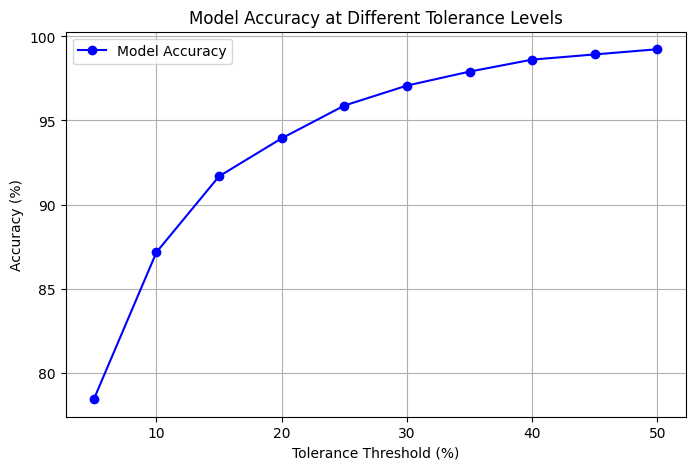

In [46]:
import matplotlib.pyplot as plt

# Define thresholds and calculate accuracy for each
accuracies = [accuracy_within_threshold(y_test, y_pred, t) for t in thresholds]

# Plot the accuracy vs. threshold
plt.figure(figsize=(8, 5))
plt.plot([t * 100 for t in thresholds], accuracies, marker='o', linestyle='-', color='b', label='Model Accuracy')

# Labels and title
plt.xlabel("Tolerance Threshold (%)")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy at Different Tolerance Levels")
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [47]:
from sklearn.model_selection import GridSearchCV

# Define the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
